<br />
<div style="text-align: center;">
    <span style="font-weight: bold; color:#6dc; font-family: 'Arial'; font-size: 2.5em;">MODIS Normalized Difference Vegetation Index</span>
</div>

In [1]:
import numpy as np
import os
import rasterio
import urllib2
import shutil
from contextlib import closing
from netCDF4 import Dataset
import datetime
import tinys3

In [2]:
def dataDownload(): 
    now = datetime.datetime.now()
    year = now.year
    month = now.month - 4

    print now
    print year
    print month
    
    remote_path = 'ftp://chg-ftpout.geog.ucsb.edu/pub/org/chg/products/CHIRPS-2.0/global_daily/tifs/p05/2017/'
    last_file = 'MOD13A2_M_NDVI_'+str(year)+'-'+"%02d" % (month,)+'.TIFF'

    local_path = os.getcwd()

    print remote_path
    print last_file
    print local_path

    with closing(urllib2.urlopen(remote_path+last_file)) as r:
        with open(last_file, 'wb') as f:
            shutil.copyfileobj(r, f)

    print local_path+'/'+last_file

    with rasterio.open(local_path+'/'+last_file) as src:
        npixels = src.width * src.height
        for i in src.indexes:
            band = src.read(i)
            print(i, band.min(), band.max(), band.sum()/npixels)

    
    return last_file

In [3]:
def tiffile(dst,outFile):
    
    
    CM_IN_FOOT = 30.48


    with rasterio.open(outFile) as src:
        kwargs = src.meta
        kwargs.update(
            driver='GTiff',
            dtype=rasterio.float64,  #rasterio.int16, rasterio.int32, rasterio.uint8,rasterio.uint16, rasterio.uint32, rasterio.float32, rasterio.float64
            count=1,
            compress='lzw',
            nodata=0,
            bigtiff='NO' # Output will be larger than 4GB
        )

        windows = src.block_windows(1)

        with rasterio.open(outFile,'w',**kwargs) as dst:
            for idx, window in windows:
                src_data = src.read(1, window=window)

                # Source nodata value is a very small negative number
                # Converting in to zero for the output raster
                np.putmask(src_data, src_data < 0, 0)

                dst_data = (src_data * CM_IN_FOOT).astype(rasterio.float64)
                dst.write_band(1, dst_data, window=window)

In [4]:
def s3Upload(outFile):
    # Push to Amazon S3 instance
    conn = tinys3.Connection(os.getenv('S3_ACCESS_KEY'),os.getenv('S3_SECRET_KEY'),tls=True)
    f = open(outFile,'rb')
    conn.upload(outFile,f,os.getenv('BUCKET'))

In [5]:
# Execution
now = datetime.datetime.now()
year = now.year
month = now.month - 4
outFile ='MOD13A2_M_NDVI_'+str(year)+'-'+"%02d" % (month,)+'.TIFF'

print 'starting'
file = dataDownload()
print 'downloaded'
tiffile(file,outFile)
print 'converted'
#s3Upload(outFile)
print 'finish'

starting
2017-06-12 17:23:19.155683
2017
2
ftp://neoftp.sci.gsfc.nasa.gov/geotiff/MOD13A2_M_NDVI/
MOD13A2_M_NDVI_2017-02.TIFF
/Users/vizzuality/Documents/Vizzuality/RW/planet_pulse/Notebooks
/Users/vizzuality/Documents/Vizzuality/RW/planet_pulse/Notebooks/MOD13A2_M_NDVI_2017-02.TIFF
(1, 0, 255, 214.15129891975309)
downloaded


/Users/vizzuality/anaconda/lib/python2.7/site-packages/rasterio/__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


converted
finish


<span style="color:#6dc; font-family: 'Arial'; font-size: 2em;">
**If I want to know how the data is like**</span>

Source:  <open RasterReader name='./MOD13A2_M_NDVI_2017-02.TIFF' mode='r'>
Source mode:  r
.TIF Shape:  (1800, 3600)
Source type: ('float64',)
CRS({'init': u'epsg:4326'})
[-180.0, 0.1, 0.0, 90.0, 0.0, -0.1]

/Users/vizzuality/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2881: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)


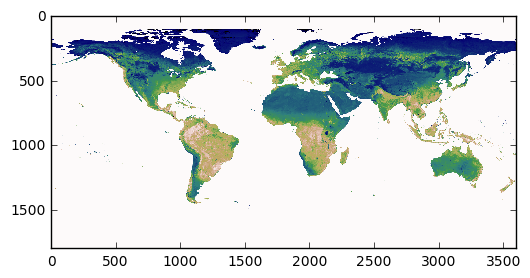

In [6]:
src = rasterio.open('./'+outFile)
print 'Source: ',src
print 'Source mode: ',src.mode

array = src.read(1)
print '.TIF Shape: ',array.shape

print 'Source type:',src.dtypes
print(src.crs)
print(src.transform)

from matplotlib import pyplot
pyplot.imshow(array, cmap='gist_earth')

pyplot.show()